# Ghana GDP

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from warnings import filterwarnings
filterwarnings("ignore")

## 1. Introduction to data and ARIMA implementation.

In [3]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


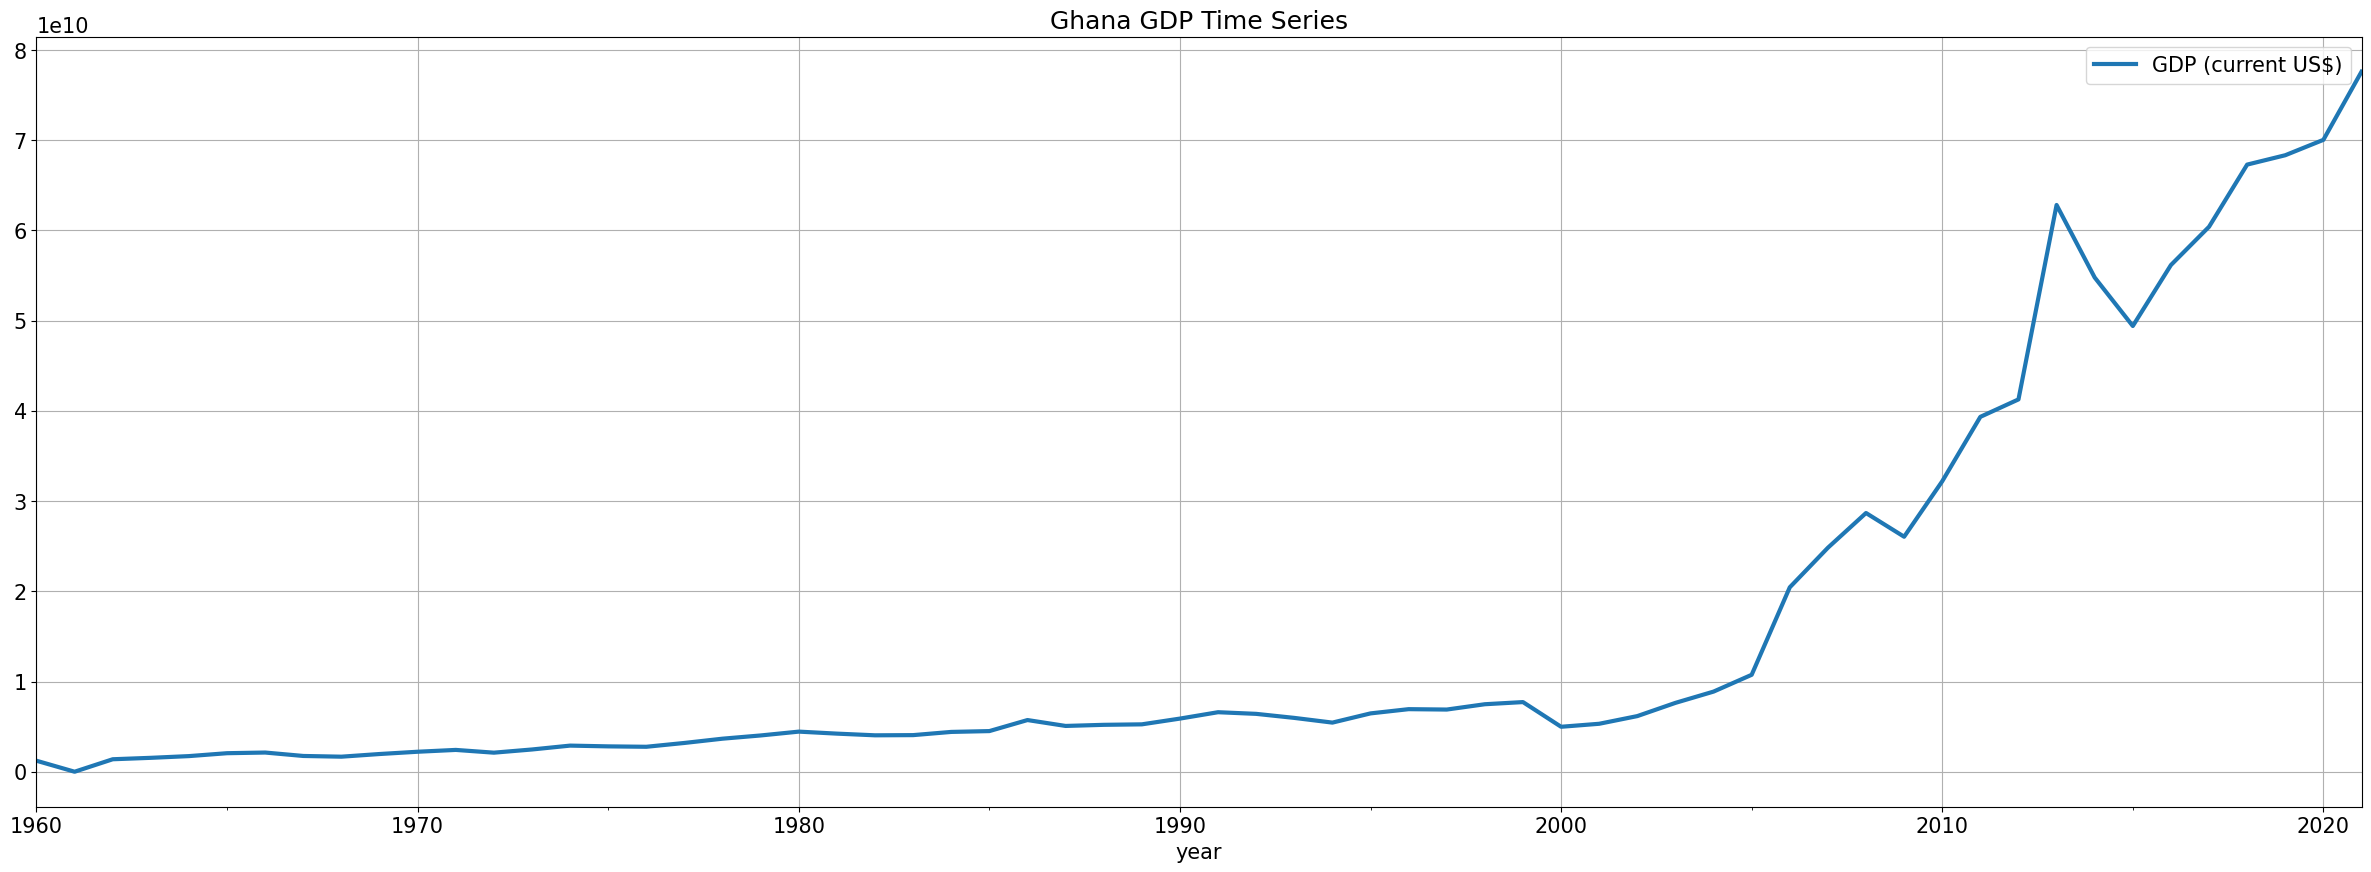

In [4]:
fig = plt.rcParams["figure.figsize"] = 30, 10
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["lines.linewidth"] = 3
data.plot()
plt.title('Ghana GDP Time Series')
plt.grid(True)
plt.show()

Allocate 3 years for the test sample:

In [5]:
test_years = 3
train_df = data.iloc[:-test_years]
test_df = data.iloc[-test_years:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

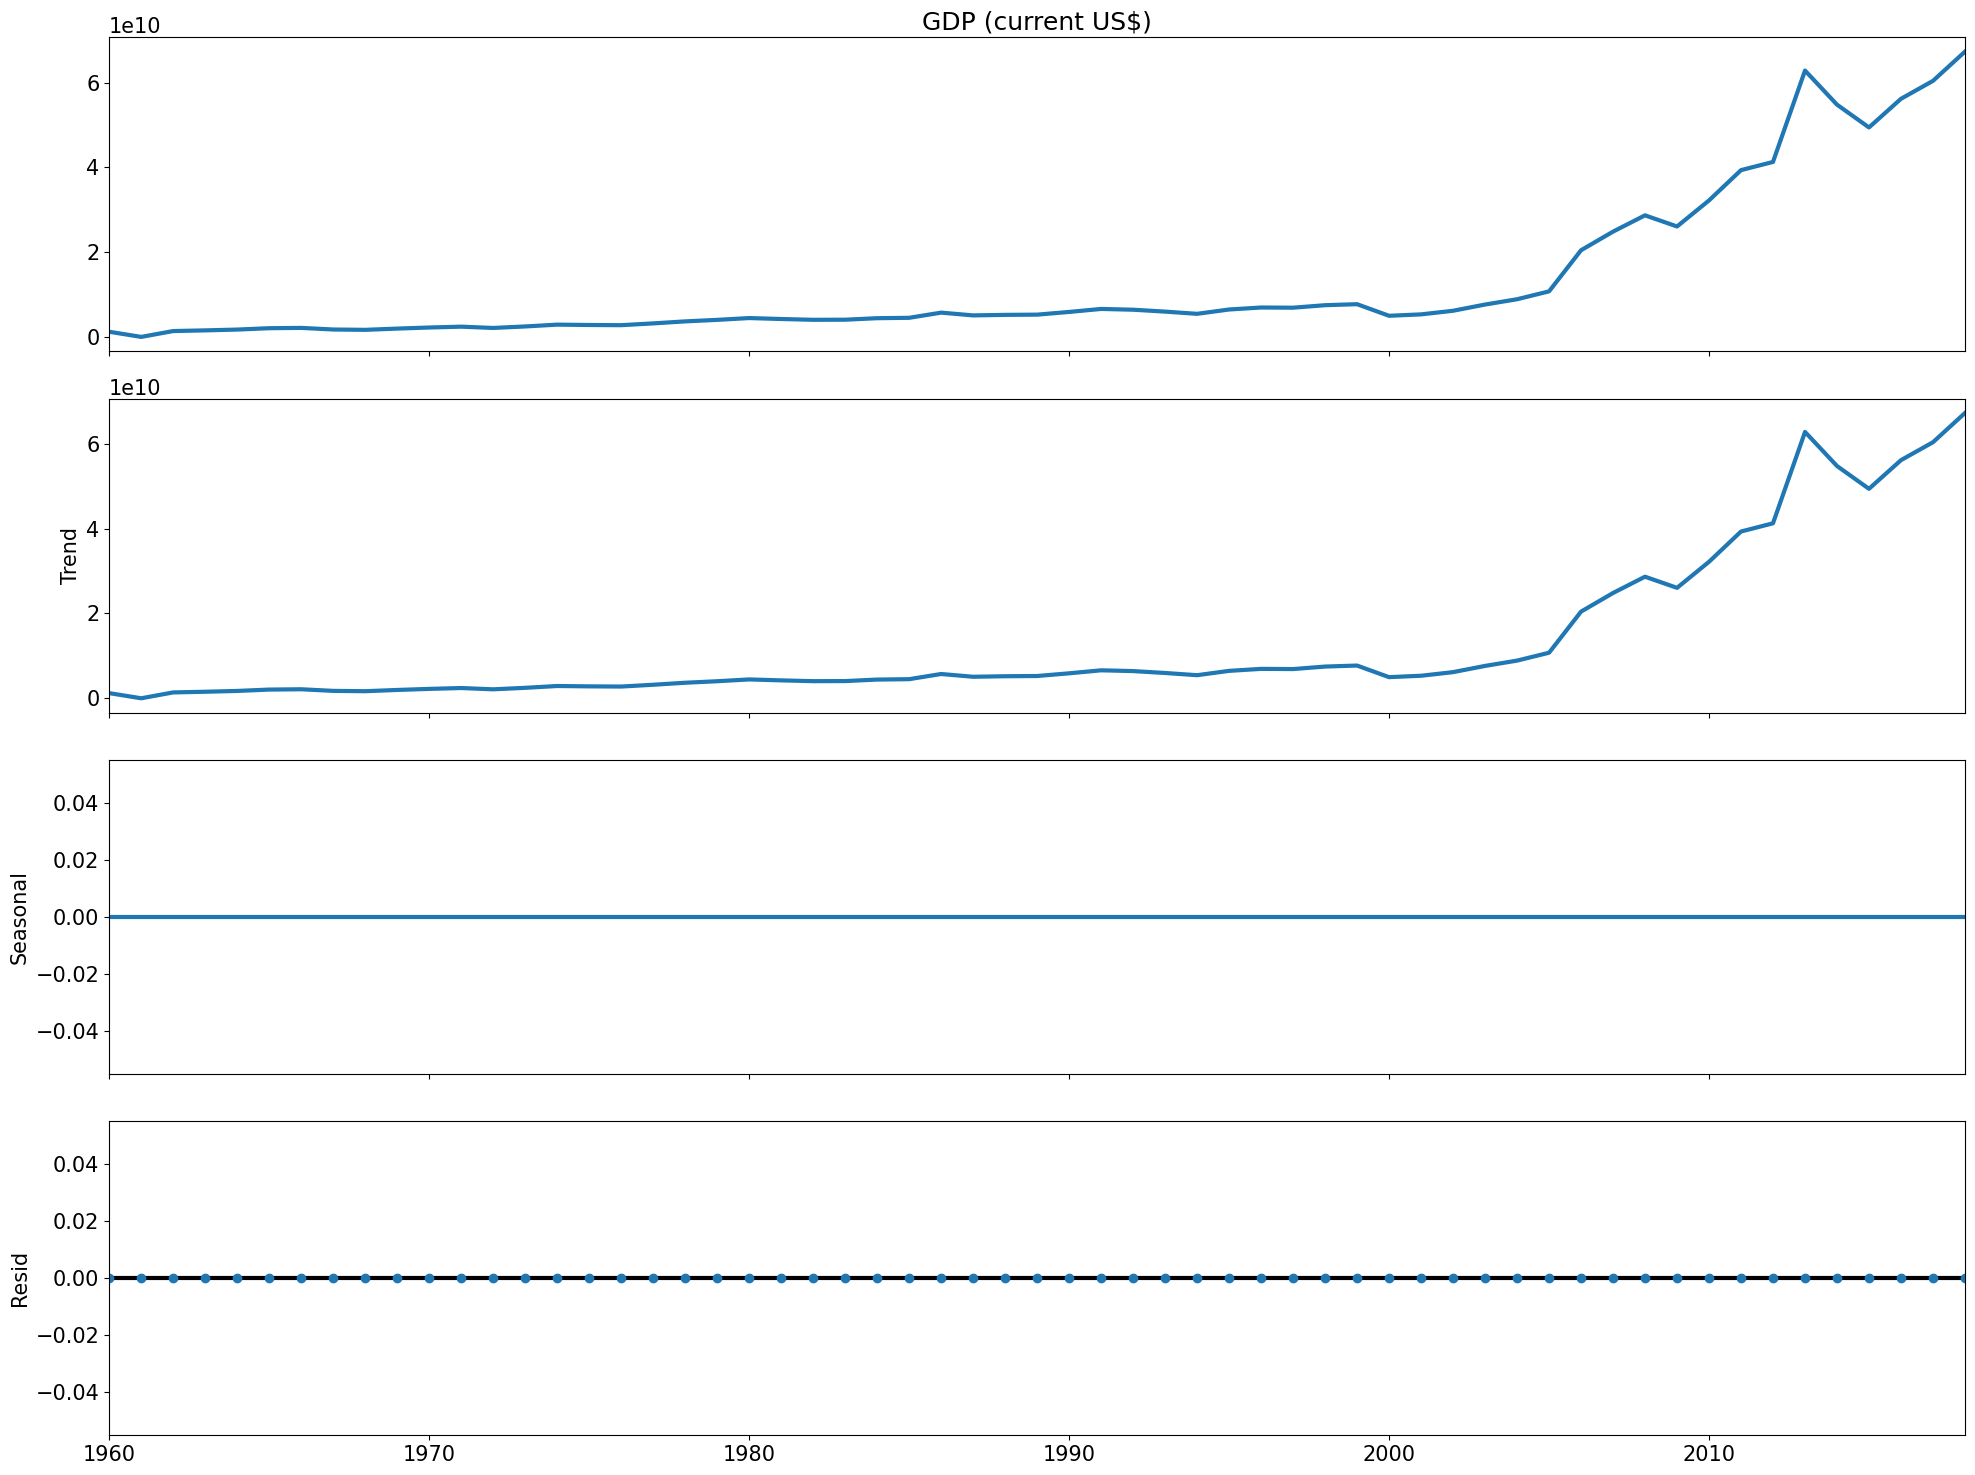

In [6]:
plt.rcParams["figure.figsize"] = 20, 15
gdp_decomposed = seasonal_decompose(train_df['GDP (current US$)'])
gdp_decomposed.plot()
plt.show()

> Decomposition revealed neither seasonal component nor residue. `seasonal_decompose` recognized the whole plot as the trend.

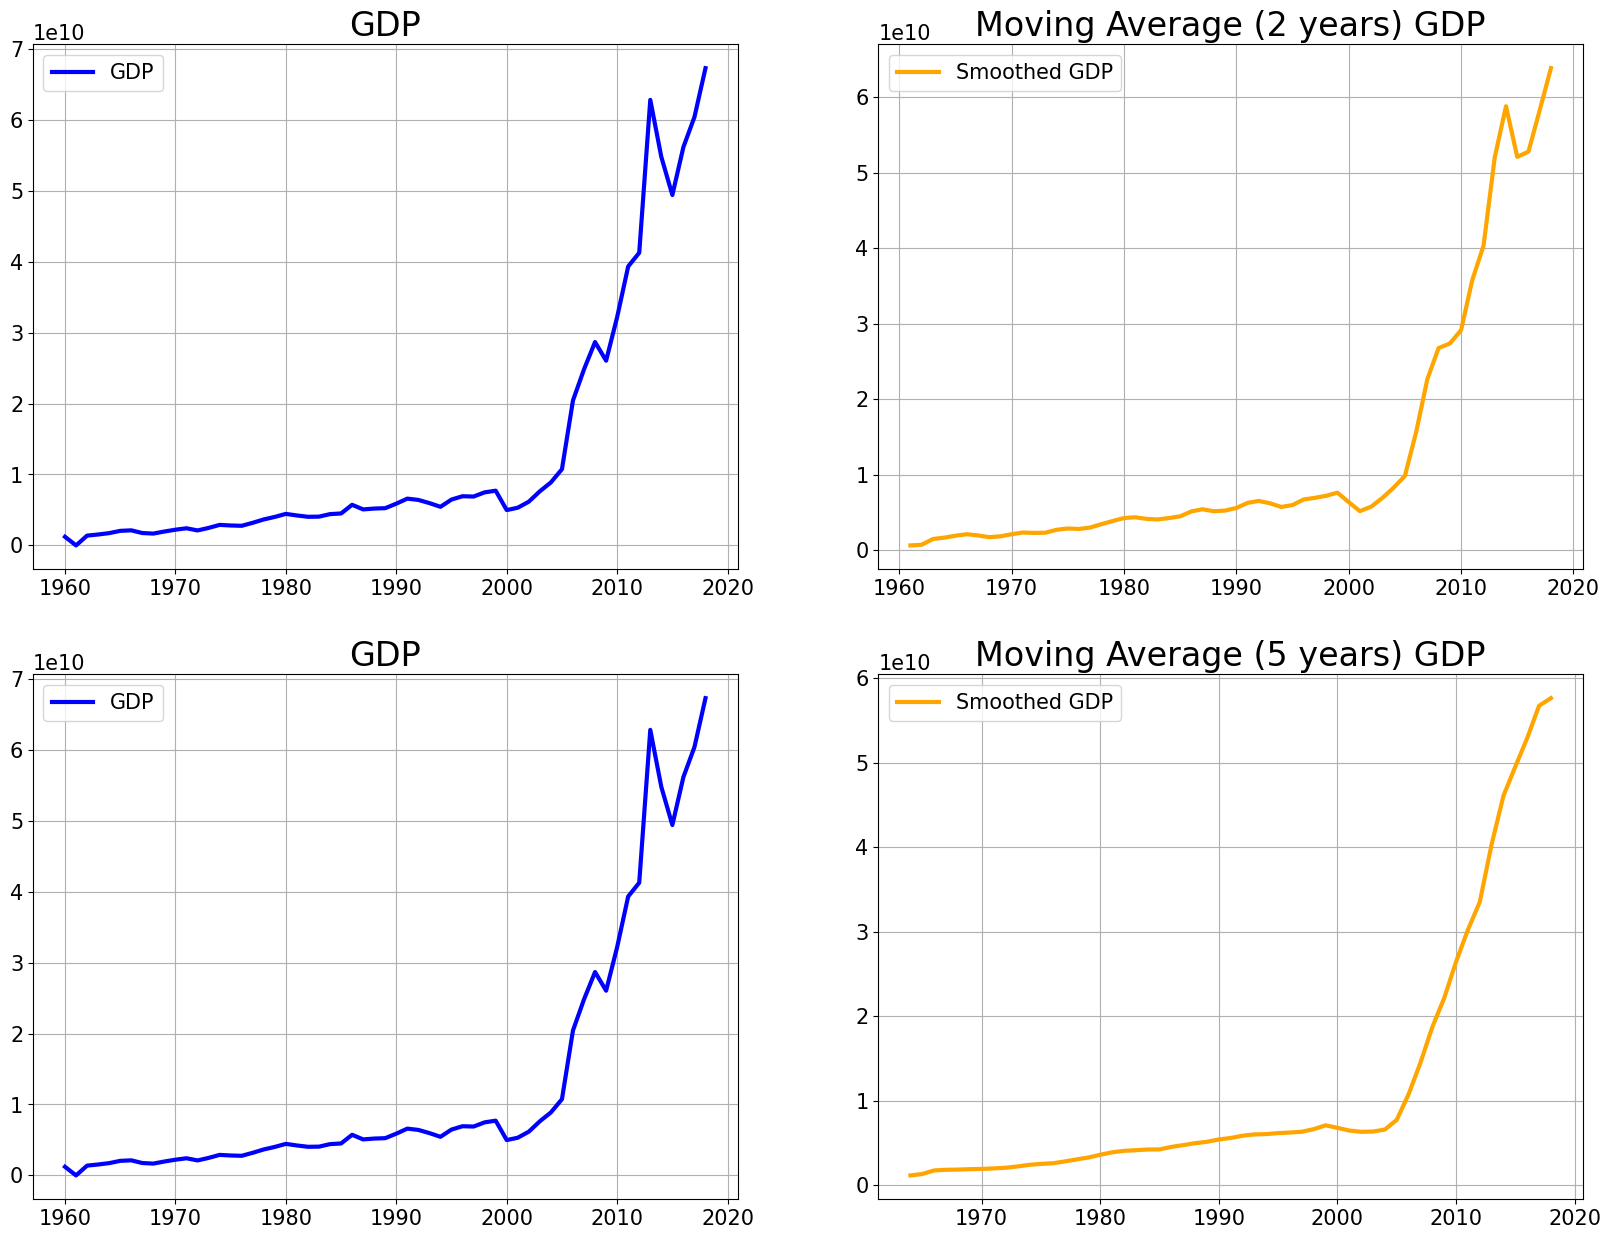

In [7]:
plt.rcParams["figure.figsize"] = 20, 15

fig, ax = plt.subplots(2, 2)

# 2-year window
ax[0, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=24)
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].plot(
    train_df['GDP (current US$)'].rolling(window=2).mean(),
    color="orange",
    label="Smoothed GDP",
)
ax[0, 1].set_title("Moving Average (2 years) GDP", size=24)
ax[0, 1].grid()
ax[0, 1].legend()


# 5-year window
ax[1, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP")
ax[1, 0].set_title("GDP", size=24)
ax[1, 0].grid()
ax[1, 0].legend()

ax[1, 1].plot(
    train_df['GDP (current US$)'].rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)
ax[1, 1].set_title("Moving Average (5 years) GDP", size=24)
ax[1, 1].grid()
ax[1, 1].legend()

plt.show()

In [8]:
def get_arima_d(feature):
    """Get ARIMA d parameter of Dickey-Fuller test implementation.

    Args:
        feature (pandas.Series): data to analyze.

    Returns:
        int, pandas.Series: d parameter, differentiated data.
    """
    
    sample = feature.copy()
    d = 0
    
    while True:
        ad_test = adfuller(sample)
        if ad_test[0] > ad_test[4]["5%"]:
            sample = sample.diff().dropna()
            d += 1
        else:
            break
        
    return d, sample

In [9]:
d, train_df_diff = get_arima_d(train_df['GDP (current US$)'])
print(f"ARIMA d parameter: {d}")

ARIMA d parameter: 3


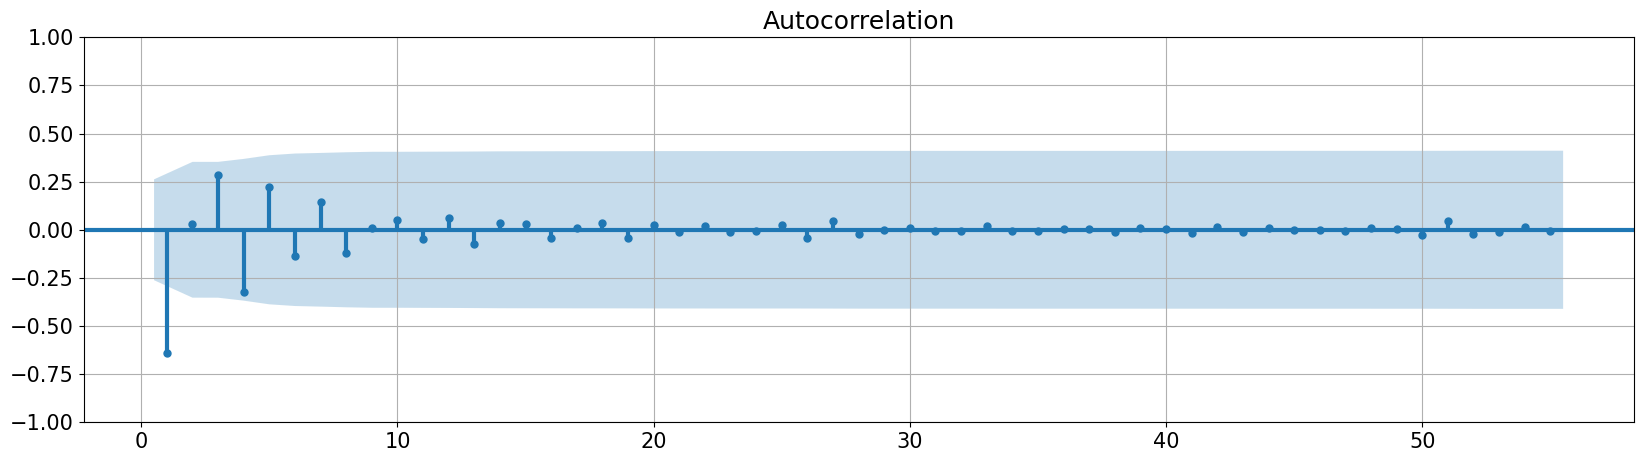

In [10]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df_diff, lags=train_df_diff.shape[0]-1, zero=False)
plt.grid(True)
plt.show()

Only the first lag is out of confident interval.

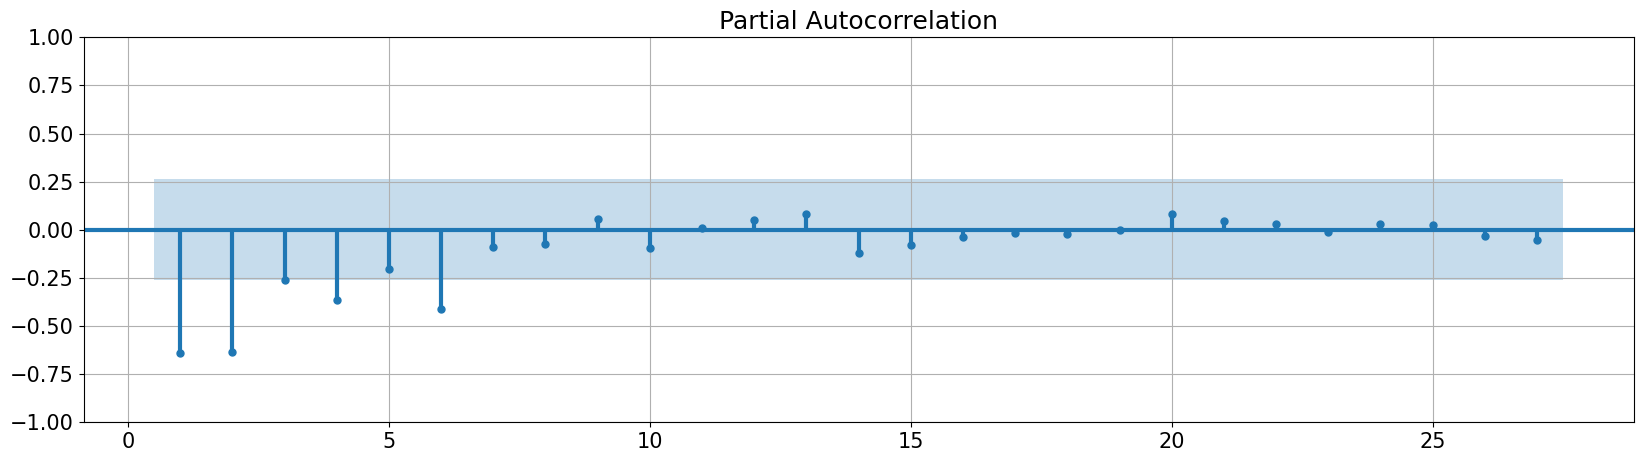

In [11]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df_diff, lags=train_df_diff.shape[0]//2 - 1, method="ywm", zero=False)
plt.grid(True)
plt.show()

PACF shows that two previous years GDP correlate with current year GDP. Therefore `p` parameter should be set to $2$.

### ARIMA

Create **ARIMA** model with the parameters:

- p = 2
- d = 3
- q = 1

In [12]:
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 15 Dec 2025   AIC                           2659.231
Time:                        04:09:17   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

Optimize hyperparameters with pmdarima:

In [13]:
auto_model = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=8,
    test="adf",
    error_action="ignore",
    trace=True,
    n_jobs=-1
)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.09 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.04 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.12 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.05 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.19 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.05 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.14 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.875 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 15 Dec 2025   AIC                           2659.231
Time:                        04:09:21   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

The set we chose earlier was the optimal one.

Prediction with confidence level $95\%$ and the optimal set:

In [14]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['GDP (current US$)'] = data['GDP (current US$)'].copy()

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

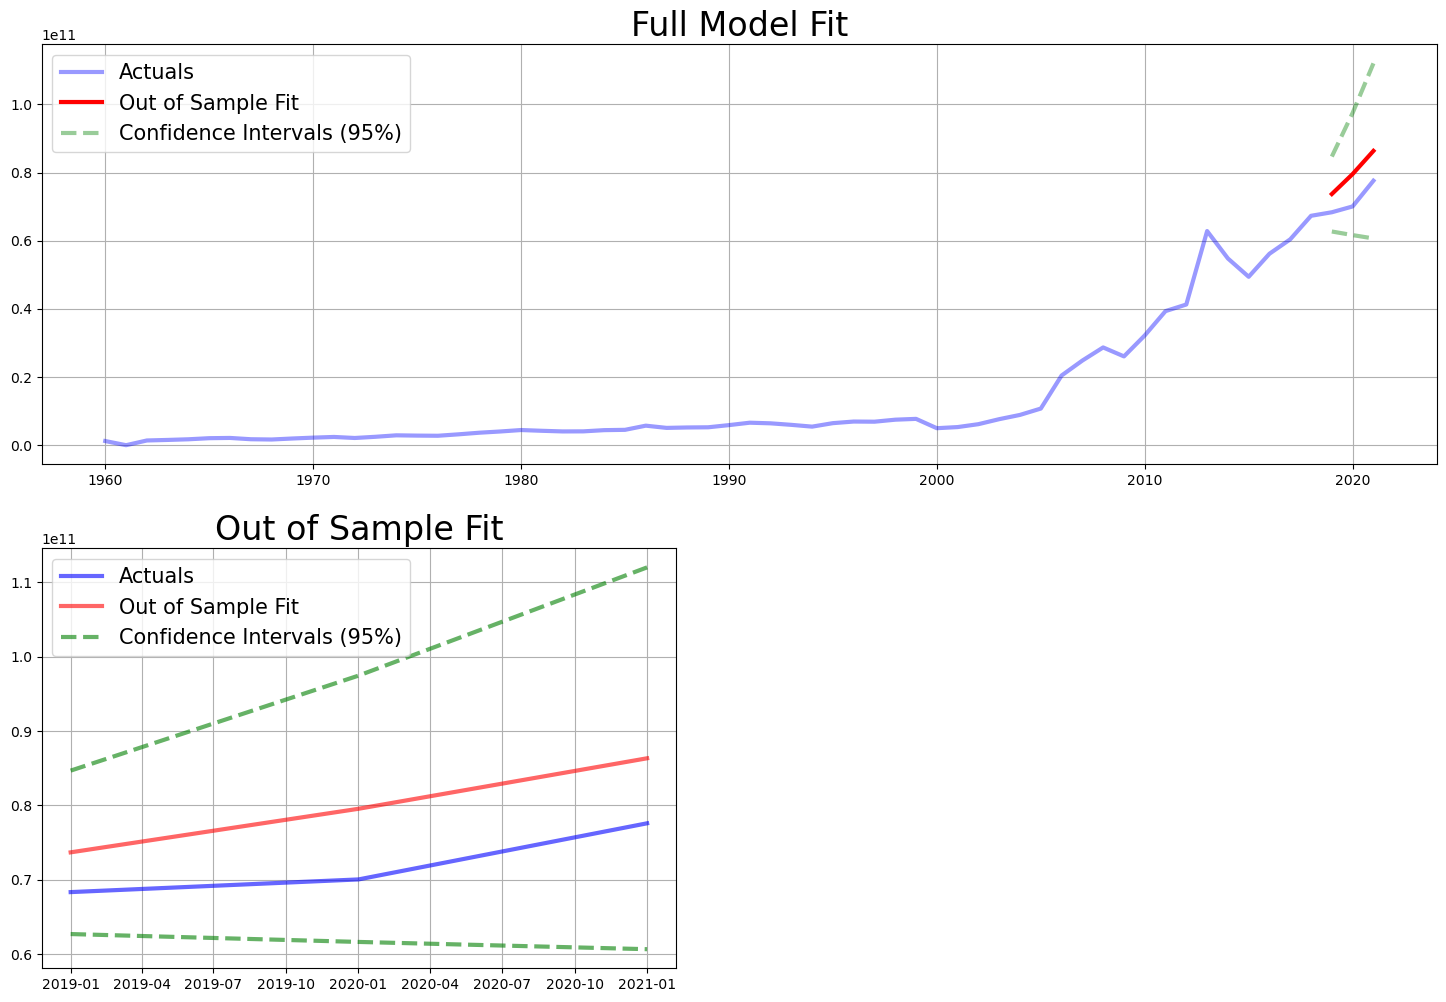

In [15]:
plt.rcParams["figure.figsize"] = 18, 12
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP (current US$)'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)
plt.grid(True)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]['GDP (current US$)'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()
plt.grid(True)
plt.show()

## 2. Interpolation and sampling

Check whether missing years are present:

In [16]:
data.asfreq(freq='YS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Check whether missing values are present:

In [21]:
data.isna().sum()

GDP (current US$)    1
dtype: int64

Replace zero values with *NaN*:

In [22]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x == 0 else x)
data.isna().sum()

GDP (current US$)    1
dtype: int64

Interpolation:

In [23]:
data_interpolate = data.copy()
data_interpolate['GDP (current US$)'] = data_interpolate['GDP (current US$)'].interpolate(method='linear')

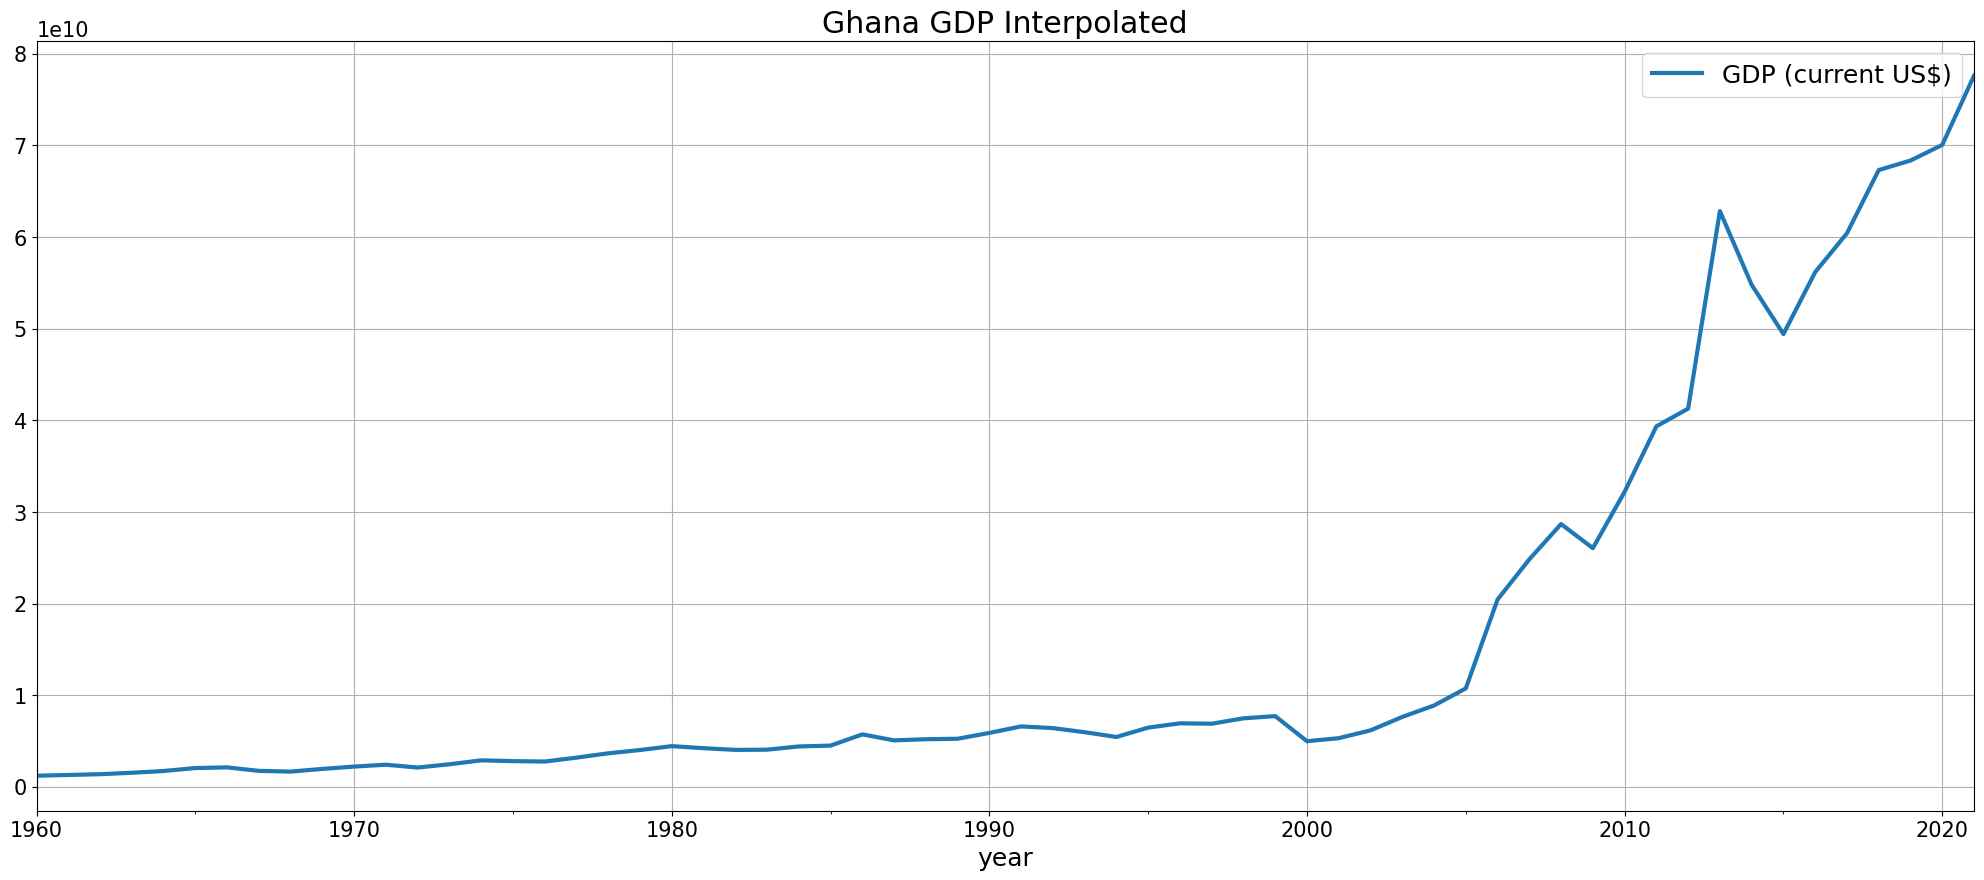

In [24]:
plt.rcParams["figure.figsize"] = 25, 10
plt.rcParams["font.size"] = 18
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["lines.linewidth"] = 3

data_interpolate.plot()
plt.title("Ghana GDP Interpolated")
plt.grid(True)
plt.show()

In [25]:
test_years = 3
train_interpolate_df = data_interpolate.iloc[:-test_years]
test_interpolate_df = data_interpolate.iloc[-test_years:]
train_interpolate_df.shape, test_interpolate_df.shape

((59, 1), (3, 1))

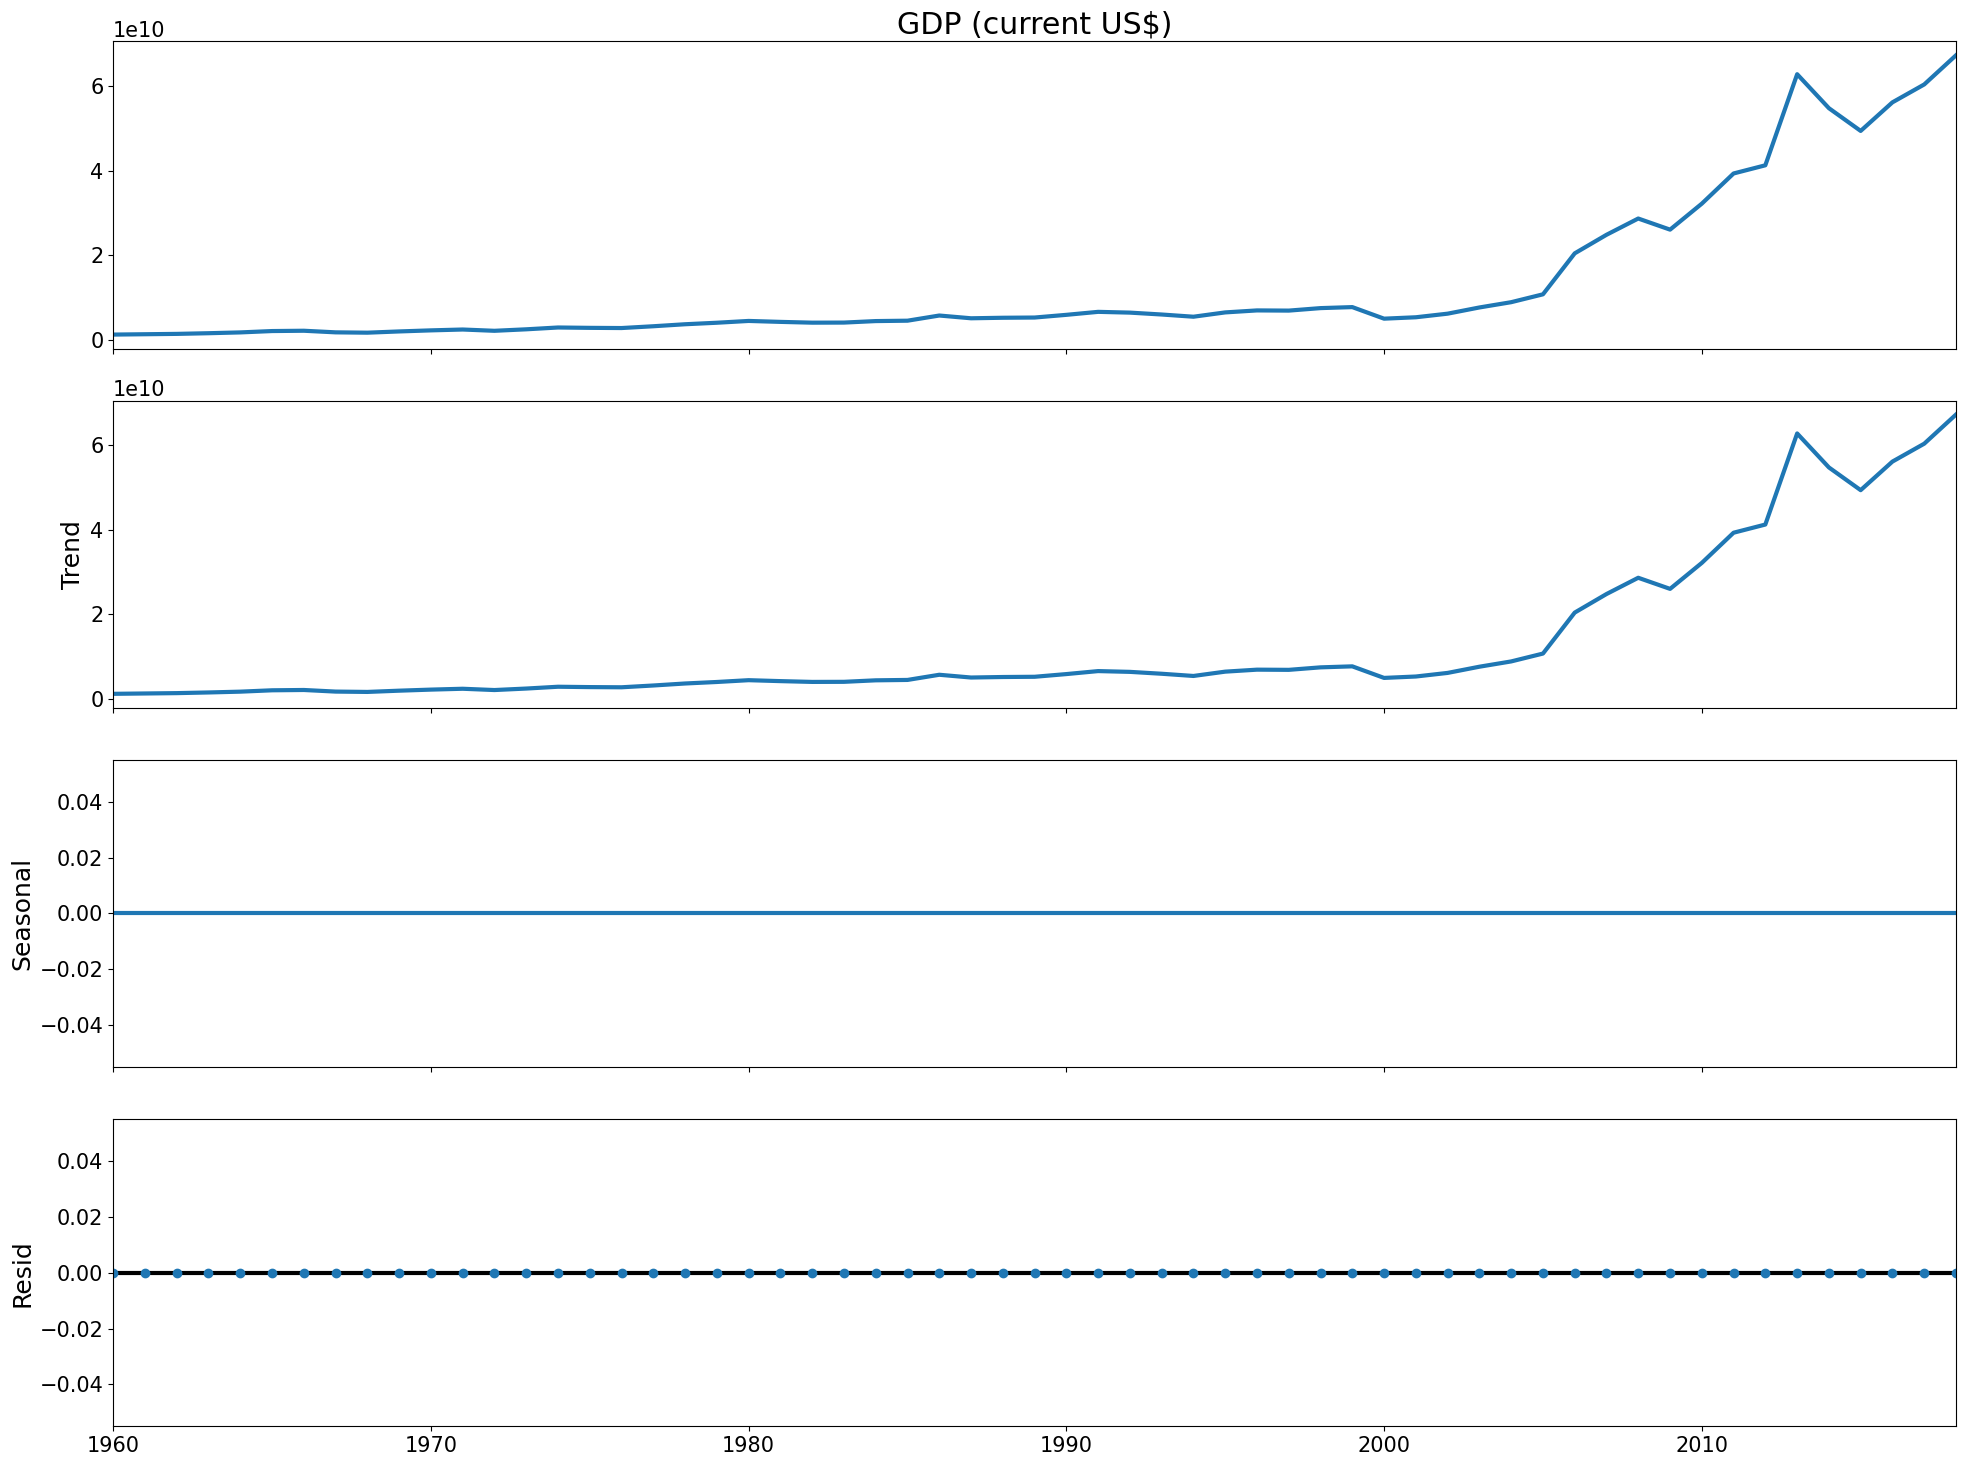

In [26]:
plt.rcParams["figure.figsize"] = 20, 15
gdp_decomposed = seasonal_decompose(train_interpolate_df['GDP (current US$)'])
gdp_decomposed.plot()
plt.show()

> Decomposition revealed neither seasonal component nor residue. `seasonal_decompose` recognized the whole plot as the trend.

In [27]:
d_inter, train_inter_diff = get_arima_d(train_interpolate_df['GDP (current US$)'])
print(f"ARIMA d parameter: {d_inter}")

ARIMA d parameter: 3


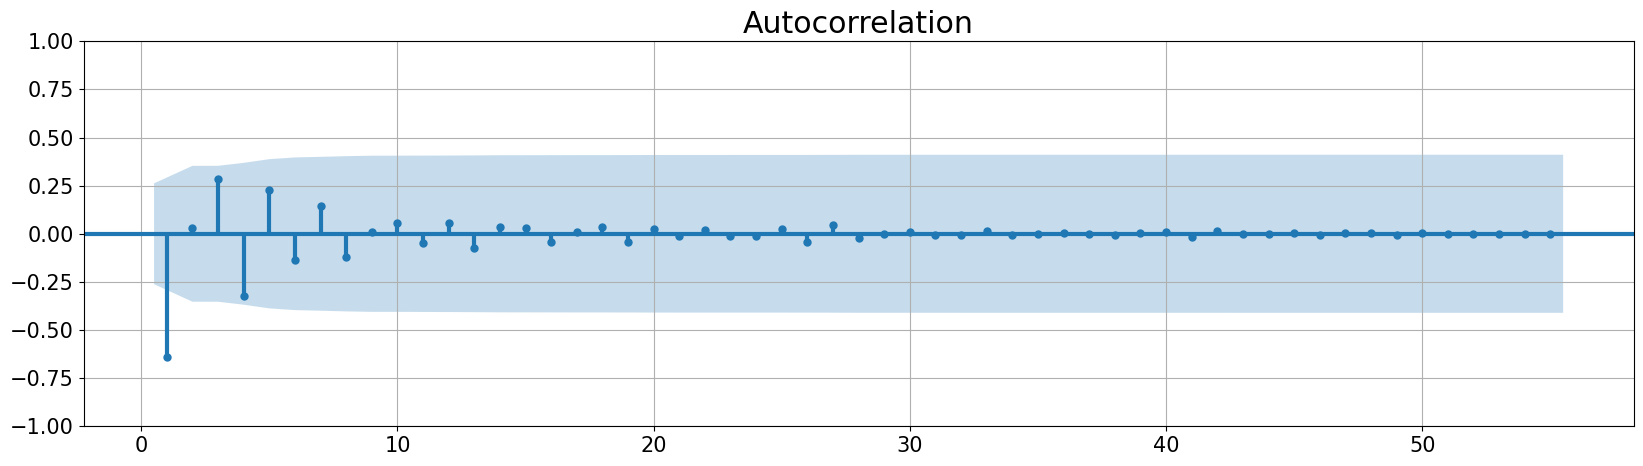

In [28]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_inter_diff, lags=train_inter_diff.shape[0]-1, zero=False)
plt.grid(True)
plt.show()

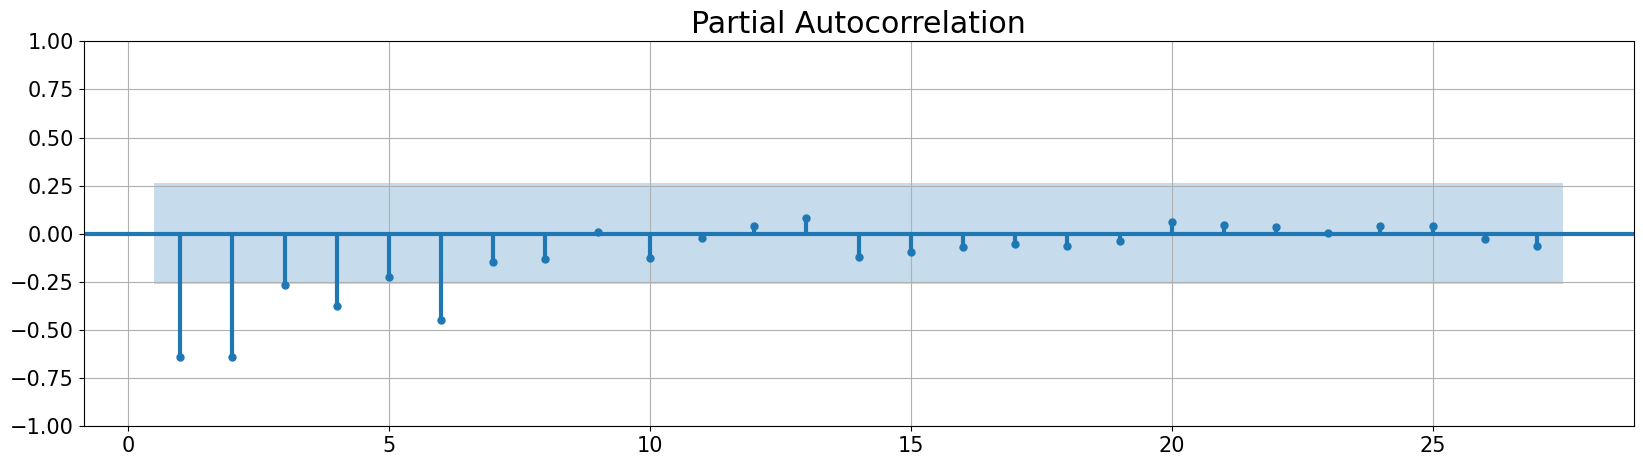

In [29]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_inter_diff, lags=train_inter_diff.shape[0]//2-1, method="ywm", zero=False)
plt.grid(True)
plt.show()

### ARIMA

Create **ARIMA** model with parameters:

- p = 2
- d = 3
- q = 1

In [30]:
arima_inter = ARIMA(train_interpolate_df['GDP (current US$)'].dropna(), order=(2, 3, 1))
arima_inter_fit = arima_inter.fit()
arima_inter_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 15 Dec 2025   AIC                           2659.226
Time:                        04:11:09   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.93e+56. Standard errors may be unstable.
"""

In [31]:
auto_inter_model = pm.auto_arima(
    train_interpolate_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
    n_jobs=-1
)

auto_inter_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.09 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.09 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.13 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.05 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.25 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.06 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.10 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.087 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 15 Dec 2025   AIC                           2659.226
Time:                        04:11:14   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.93e+56. Standard errors may be unstable.
"""

> In this case interpolation altered neither set of parameters nor `AIC`. This may be so because we have only one value to interpolate.

Prediction on interpolated data:

In [32]:
pred_inter_df = pd.DataFrame(index=data_interpolate.index)

pred_inter_df['model_preds'] = arima_inter_fit.predict(start=test_interpolate_df.index[0], 
                                                       end=test_interpolate_df.index[-1])
pred_inter_df['GDP (current US$)'] = data_interpolate['GDP (current US$)'].copy()

forecast_inter = arima_inter_fit.get_forecast(len(test_interpolate_df.index))
forecast_inter_df = forecast_inter.conf_int(alpha=0.05)  # Confidence level 95%

pred_inter_df.at[test_interpolate_df.index, 'model_preds_lower'] = forecast_inter_df['lower GDP (current US$)']
pred_inter_df.at[test_interpolate_df.index, 'model_preds_upper'] = forecast_inter_df['upper GDP (current US$)']

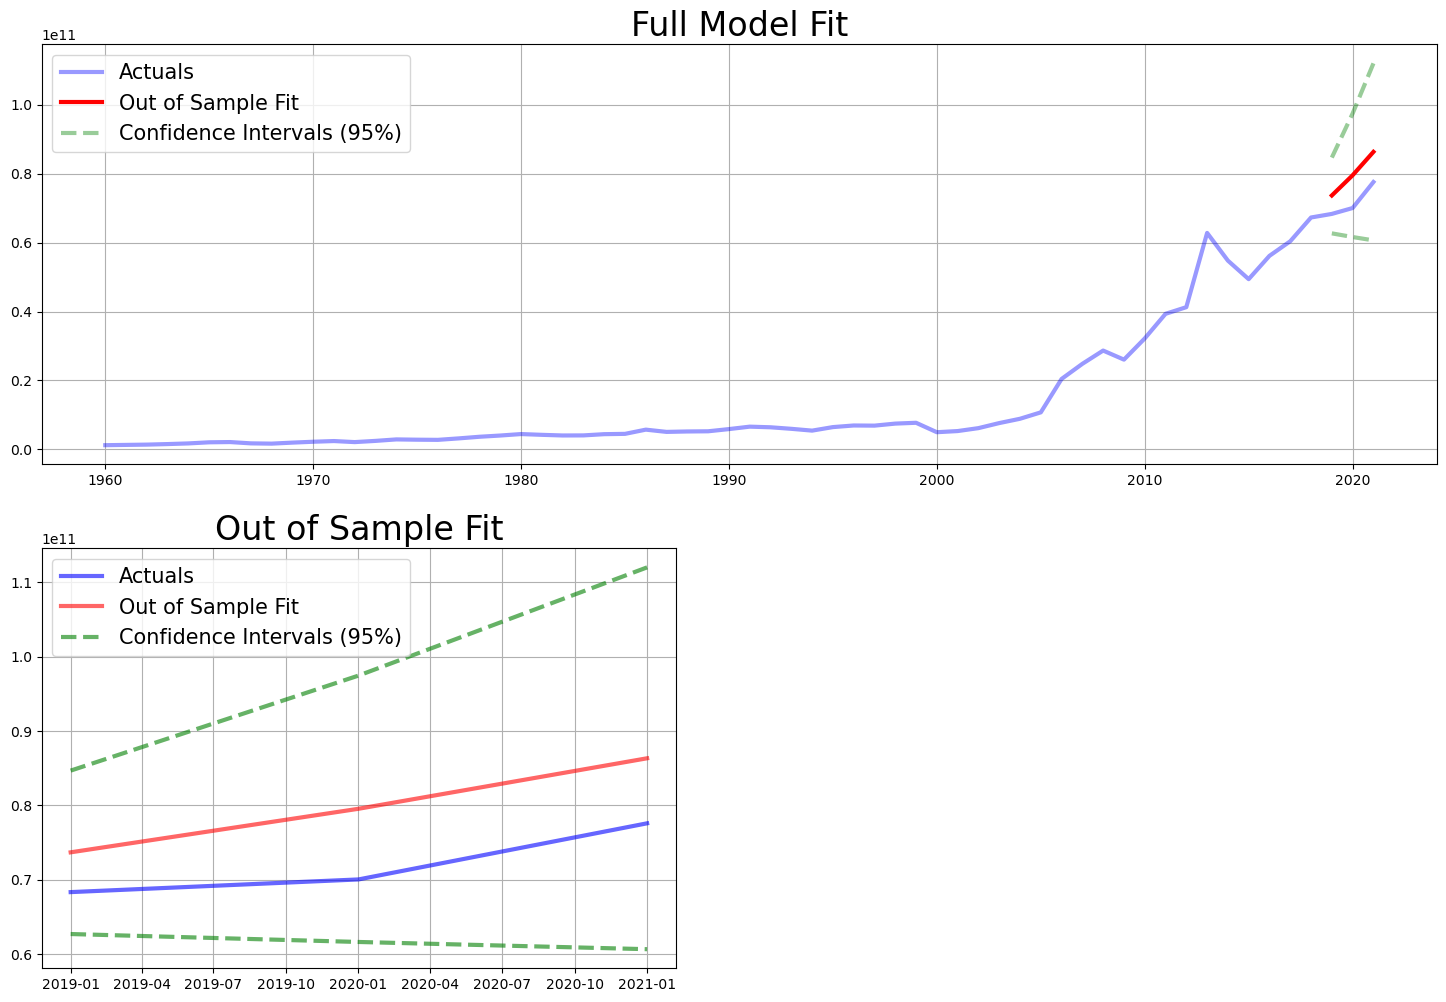

In [33]:
plt.rcParams["figure.figsize"] = 18, 12
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

plt.subplot(2, 1, 1)
plt.plot(pred_inter_df['GDP (current US$)'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_inter_df.loc[test_interpolate_df.index]['model_preds'],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_inter_df.loc[test_interpolate_df.index]['model_preds_lower'],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_inter_df.loc[test_interpolate_df.index]['model_preds_upper'],
    color="green",
    linestyle="--",
    alpha=0.4,
)
plt.grid(True)
plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_inter_df.loc[test_interpolate_df.index]['GDP (current US$)'], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_inter_df.loc[test_interpolate_df.index]['model_preds'],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_inter_df.loc[test_interpolate_df.index]['model_preds_lower'],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_inter_df.loc[test_interpolate_df.index]['model_preds_upper'],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()
plt.grid(True)
plt.show()

## 3. Volatility prediction.

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [34]:
data = data_interpolate.copy()
data['GDP_volatility'] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data['GDP_volatility'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_volatility, dtype: float64

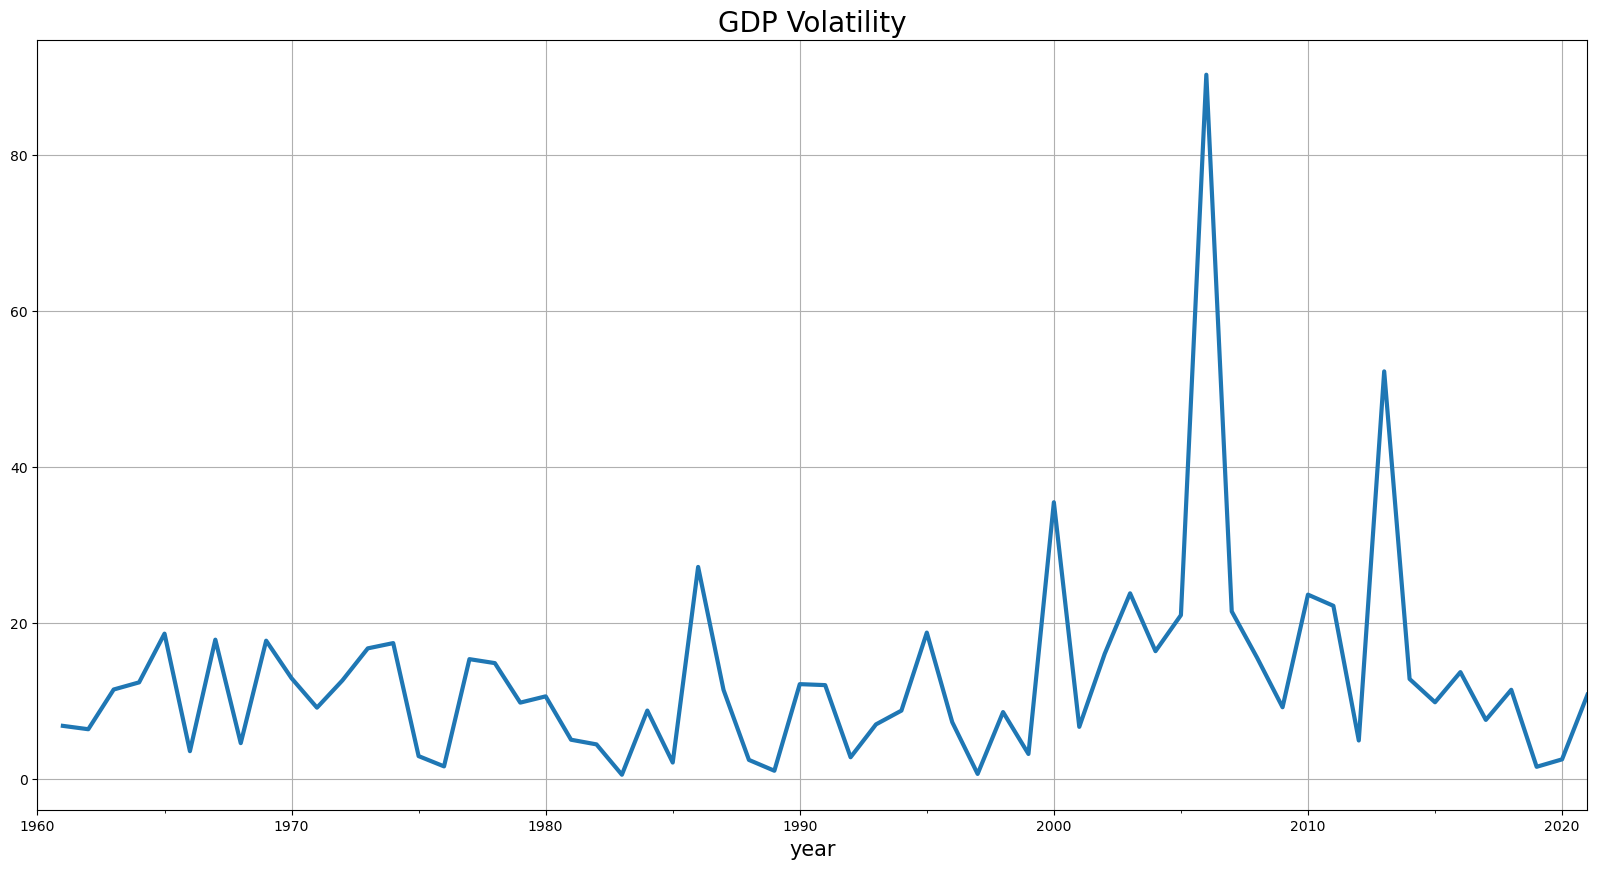

In [35]:
plt.rcParams["figure.figsize"] = 20, 10
data['GDP_volatility'].plot()
plt.title("GDP Volatility", size=20)
plt.grid(True)
plt.show()

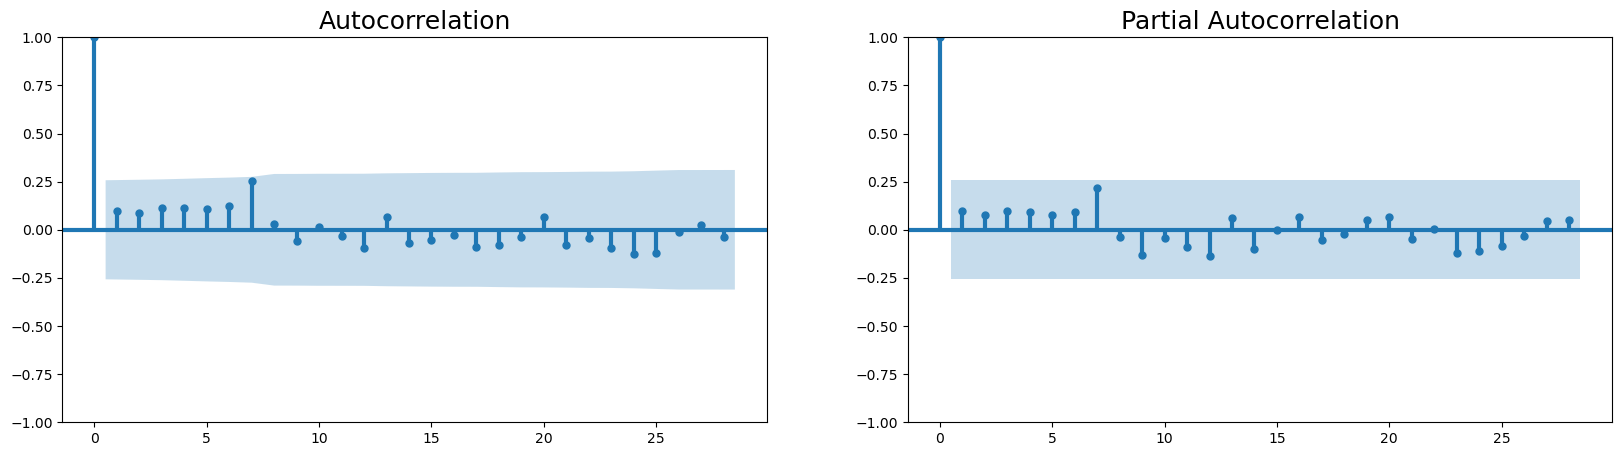

In [36]:
test_years = 3
train_df = data.iloc[:-test_years]
test_df = data.iloc[-test_years:]

plt.rcParams["figure.figsize"] = 20, 5
fig, axes = plt.subplots(1, 2)
sgt.plot_acf(train_df['GDP_volatility'][1:], ax=axes[0], lags=train_df.shape[0]//2 - 1)
sgt.plot_pacf(train_df['GDP_volatility'][1:], ax=axes[1], lags=train_df.shape[0]//2 - 1, method="ywm")
plt.show()
plt.rcParams["figure.figsize"] = 20, 5

In [37]:
d, train_df_diff = get_arima_d(train_df['GDP_volatility'][1:])
print(f"ARIMA d parameter: {d}")

ARIMA d parameter: 0


In [38]:
garch_df = pd.DataFrame(data['GDP_volatility'].loc[data.index])

model = arch_model(garch_df['GDP_volatility'].dropna(), p=7, q=7, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38048115955718
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759052175603
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.40871495512866
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10079395318482
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01143994526097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.00780231871062
            Iterations: 29
            Function evaluations: 492
            Gradient evaluations: 28


In [39]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         GDP_volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.008
Distribution:                  Normal   AIC:                           460.016
Method:            Maximum Likelihood   BIC:                           492.983
                                        No. Observations:                   58
Date:                Mon, Dec 15 2025   Df Residuals:                       57
Time:                        04:11:42   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.8666      1.572      7.550  4.349e-14 [  8.786, 14.947]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.1055     42.301      1.043      0.297    [-38.802,1.270e+02]
alpha[1]   3.2351e-08  7.767e-02  4.165e-07      1.000      [ -0.152,  0.152]
alpha[2]   7.8463e-08  2.299e-02  3.412e-06      1.000 [-4.507e-02,4.507e-02]
alpha[3]   6.5621e-14  6.853e-02  9.576e-13      1.000      [ -0.134,  0.134]
alpha[4]   3.6162e-03  1.492e-02      0.242      0.809 [-2.563e-02,3.286e-02]
alpha[5]   6.2496e-14  1.274e-02  4.906e-12      1.000 [-2.497e-02,2.497e-02]
alpha[6]       0.7319      0.915      0.800      0.424      [ -1.062,  2.525]
alpha[7]       0.1024      0.643      0.159      0.873      [ -1.157,  1.362]
beta[1]    5.7084e-07      0.501  1.139e-06      1.000      [ -0.982,  0.982]
beta[2]    3.6496e-07  6.190e-02  5.896e-06      1.000      [ -0.121,  0.121]
beta[3]    3.4349e-07  2.869e-02  1.197e-05      1.000 [-5.624e-02,5.624e-02]
beta[4]    3.0295e-07  9.122e-02  3.321e-06      1.000      [ -0.179,  0.179]
beta[5]    1.7888e-05  5.268e-02  3.396e-04      1.000      [ -0.103,  0.103]
beta[6]    3.6179e-07  3.014e-02  1.200e-05      1.000 [-5.908e-02,5.908e-02]
beta[7]    2.9083e-07      1.155  2.517e-07      1.000      [ -2.265,  2.265]
=============================================================================

Covariance estimator: robust
"""

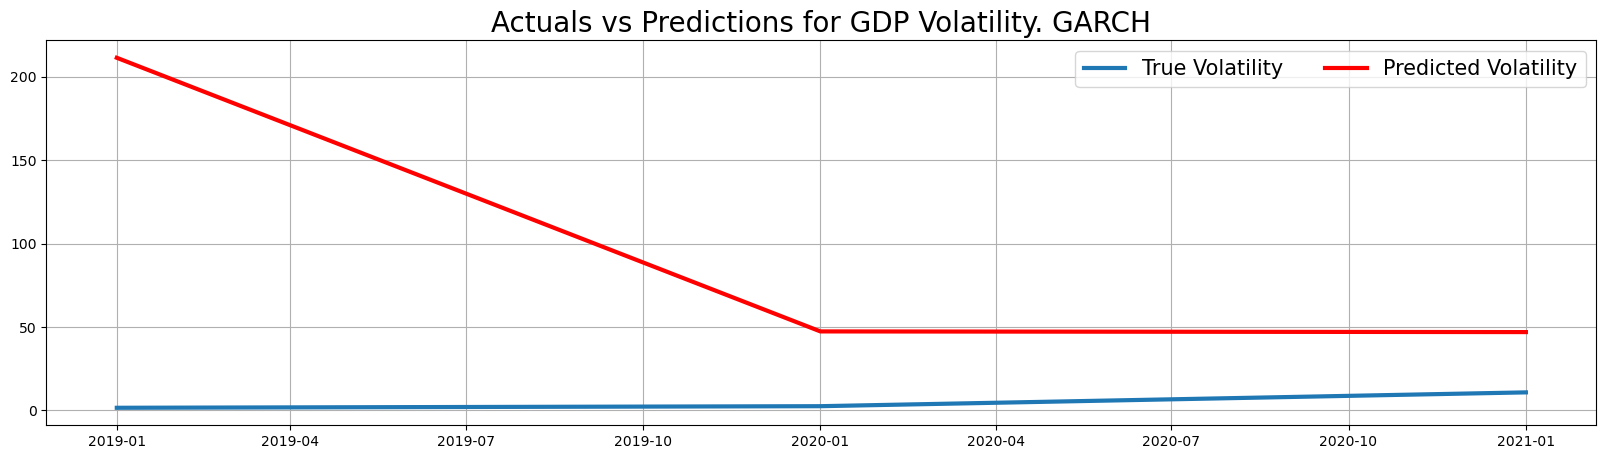

In [40]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

plt.rcParams["figure.figsize"] = 20, 5

plt.plot(predictions_df['GDP_volatility'].abs(), label="True Volatility")
plt.plot(predictions_df["Predictions"], color="red", label="Predicted Volatility")
plt.grid(True)
plt.legend(ncol=2)
plt.title("Actuals vs Predictions for GDP Volatility. GARCH", size=20)

plt.show()

In [41]:
print(f"MSE, p=7, q=7: {mean_squared_error(predictions_df['GDP_volatility'].abs(), predictions_df['Predictions'])}")

MSE, p=7, q=7: 15799.81566534356


Trying to use another set of parameters:

In [42]:
model = arch_model(garch_df['GDP_volatility'].dropna(), p=6, q=6, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     84,   Neg. LLF: 216.54019105018943
Iteration:     10,   Func. Count:    161,   Neg. LLF: 215.0392977660696
Iteration:     15,   Func. Count:    236,   Neg. LLF: 214.47228795187962
Iteration:     20,   Func. Count:    311,   Neg. LLF: 214.37552574244015
Iteration:     25,   Func. Count:    386,   Neg. LLF: 214.3739950954855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.3739950954855
            Iterations: 26
            Function evaluations: 400
            Gradient evaluations: 26


In [43]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         GDP_volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.374
Distribution:                  Normal   AIC:                           456.748
Method:            Maximum Likelihood   BIC:                           485.594
                                        No. Observations:                   58
Date:                Mon, Dec 15 2025   Df Residuals:                       57
Time:                        04:12:04   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.7917      1.225      9.623  6.414e-22 [  9.390, 14.193]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         41.1336     14.646      2.809  4.977e-03      [ 12.428, 69.839]
alpha[1]       0.0000  7.532e-03      0.000      1.000 [-1.476e-02,1.476e-02]
alpha[2]       0.0000  1.539e-02      0.000      1.000 [-3.016e-02,3.016e-02]
alpha[3]   5.0905e-09  3.147e-02  1.617e-07      1.000 [-6.168e-02,6.168e-02]
alpha[4]   3.8562e-03  5.396e-03      0.715      0.475 [-6.720e-03,1.443e-02]
alpha[5]   1.6947e-09  5.782e-03  2.931e-07      1.000 [-1.133e-02,1.133e-02]
alpha[6]       0.7664      0.419      1.827  6.767e-02   [-5.570e-02,  1.589]
beta[1]        0.0893  5.170e-02      1.727  8.414e-02   [-1.204e-02,  0.191]
beta[2]        0.0000  2.520e-02      0.000      1.000 [-4.939e-02,4.939e-02]
beta[3]        0.0000  1.569e-02      0.000      1.000 [-3.075e-02,3.075e-02]
beta[4]        0.0000  3.550e-02      0.000      1.000 [-6.959e-02,6.959e-02]
beta[5]        0.0000  4.104e-02      0.000      1.000 [-8.043e-02,8.043e-02]
beta[6]        0.0000  2.130e-02      0.000      1.000 [-4.175e-02,4.175e-02]
=============================================================================

Covariance estimator: robust
"""

> Set $p = 6$, $q = 6$ shows lower `AIC`.

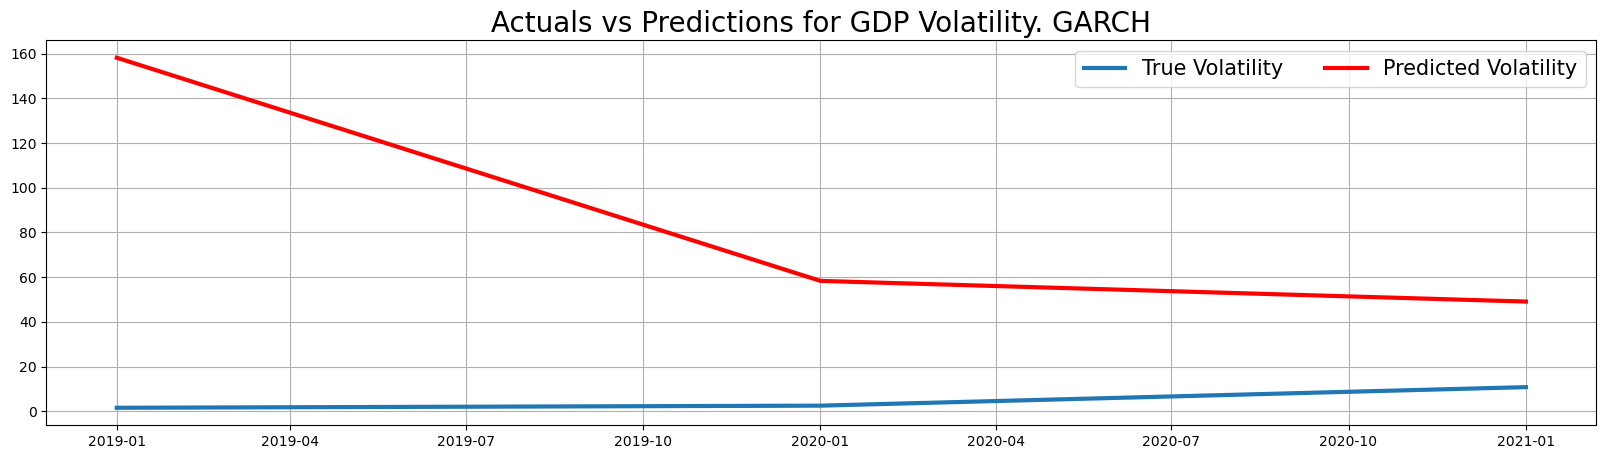

In [44]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

plt.rcParams["figure.figsize"] = 20, 5

plt.plot(predictions_df['GDP_volatility'].abs(), label="True Volatility")
plt.plot(predictions_df["Predictions"], color="red", label="Predicted Volatility")
plt.grid(True)
plt.legend(ncol=2)
plt.title("Actuals vs Predictions for GDP Volatility. GARCH", size=20)

plt.show()

In [45]:
print(f"MSE, p=6, q=6: {mean_squared_error(predictions_df['GDP_volatility'].abs(), predictions_df['Predictions'])}")

MSE, p=6, q=6: 9705.468527407585


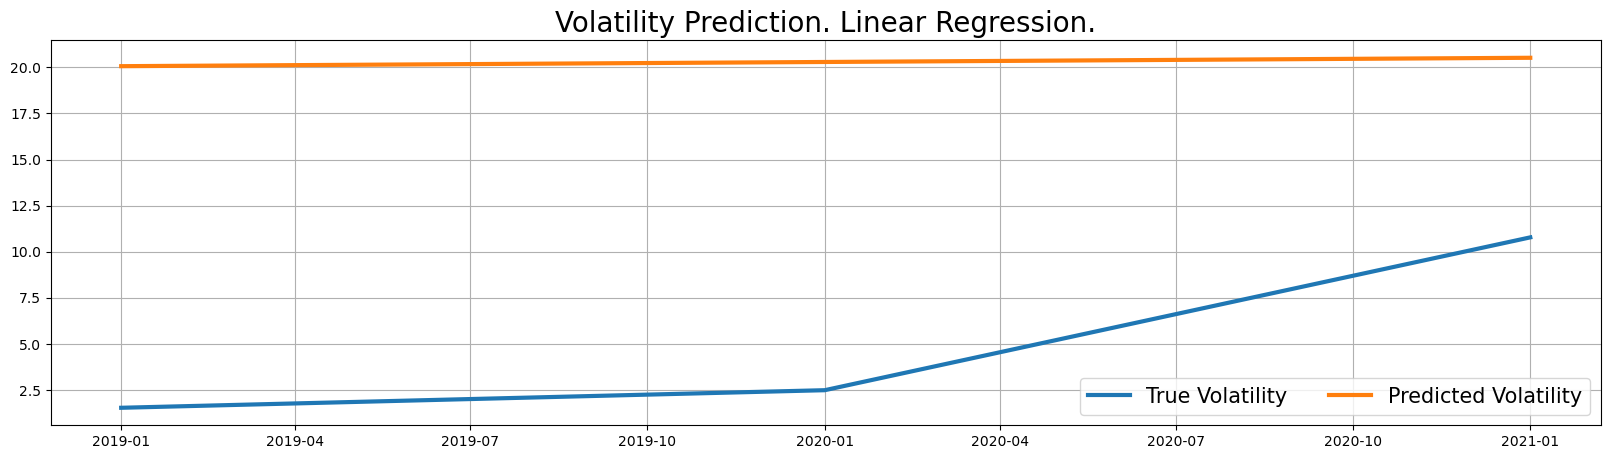

In [46]:
X_train = pd.DataFrame(range(data['GDP_volatility'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['GDP_volatility'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['GDP_volatility'].fillna(0)
y_test = test_df['GDP_volatility'].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

plt.plot(y_test, label="True Volatility")
plt.plot(pd.Series(lr_predict, index=y_test.index), label="Predicted Volatility")
plt.title("Volatility Prediction. Linear Regression.", size=20)
plt.grid(True)
plt.legend(ncol=2)

plt.show()

In [47]:
print(f"MSE, Linear regression: {mean_squared_error(y_test, lr_predict)}")

MSE, Linear regression: 251.40893776471296


> Generally, one-dimensional linear regression is a weak model. Better `MSE` we got using linear regression may be the result of the volatility plot behaviour. Since the plot rises and falls all the time `GARCH` model learned on that data fails to predict relatively straight part of the plot. We can't make conclusions about model's strength regarding only one case.